In [47]:
import requests                # Include HTTP Requests module
from bs4 import BeautifulSoup  # Include BS web scraping module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [48]:
gameID = 'loyola-university-chicago/boxscore/4822'
url = "https://meangreensports.com/sports/mens-basketball/stats/2020-21/" + gameID
r = requests.get(url,verify=False)
soup = BeautifulSoup(r.text, "html.parser")
prds = soup.find_all('section', attrs = {'id':'play-by-play'})


C:\Users\scohendevries\AppData\Local\Continuum\miniconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [49]:
dfRaw = pd.DataFrame()
for i in prds:
    p = 1
    T = '00:20:00'
    team = ''
    action = ''
    plr = ''
    for prd in i.find_all('div',id=re.compile(r'period')):
        for pos in prd.find_all('tr')[1:]:
            t = pos.find('th',attrs={'scope':'row'}).text
            if re.search(r'\d',t):
                T = t
            a = pos.find(lambda tag: tag.name == 'td' and 
                                   tag.get('class') == ['text-right','hide-on-medium-down']).text.strip()
            h = pos.find(lambda tag: tag.name == 'td' and 
                                   tag.get('class') == ['hide-on-medium-down']).text.strip()
            if len(a)>0:
                team = 'A'
                action = a
            else:
                team = 'H'
                action = h
            try:
                plr = action.split(' by ')[1]
            except:
                print(action)
            dfRaw = pd.concat([dfRaw,
                              pd.DataFrame([[p,T,team,action,plr]],
                                          columns=['Period','Time','Team','ActionRaw','Player'])
                              ])
        p += 1

dfRaw['Action'] = dfRaw.ActionRaw.str.extract('([^a-z]{2,})')

In [50]:
def cleanAction(x):
    x = re.sub('^\d+', '', x).lstrip()
    x = re.sub('\d+$', '', x).rstrip()
    x = re.sub(' by$', '', x).rstrip()
    return x
def cleanPeriod(x):
    x = int(''.join(filter(str.isdigit, x)))
    return x
def cleanPlayer(x):
    x = x.lstrip().rstrip()
    return x
def getStarters(df):
    nprd = df['Period'].max()

    periodStart = pd.to_timedelta('00:00:00')
    periodEnd = pd.to_timedelta('00:40:00')
    if nprd > 2:
        n = nprd - 2
        while n > 0:
            periodEnd += pd.to_timedelta('00:05:00')
            n -= 1
    lineups2 = df[df.Action.isin(['SUB IN','SUB OUT'])
                 ][['Player','Action','Time','Period','Team']]
    
    linePV = pd.pivot_table(lineups2,index=['Player','Team'],columns='Action',values='Time',aggfunc=np.min).reset_index()
    linePV['SUB IN'] = linePV['SUB IN'].fillna(periodStart)
    linePV['SUB OUT'] = linePV['SUB OUT'].fillna(periodEnd)
    
    starters = linePV[
        (
            (linePV['SUB OUT'] < linePV['SUB IN'])
        )
        |
        (
            (linePV['SUB IN'] == '00:00:00')
        )
                     ][['Team','Player','SUB OUT','SUB IN']]
    return list(starters[starters['Team']=='H']['Player']),list(starters[starters['Team']=='A']['Player'])

def getStartersByPeriod(df,p):
    periodStart = pd.to_timedelta('00:00:00')
    periodEnd = pd.to_timedelta('00:20:00')
    if p > 2:
        periodEnd = pd.to_timedelta('00:05:00')
    lineups2 = df[
        df.Action.isin(['SUB IN','SUB OUT'])
                 ][['Player','Action','Time','Period','Team']]
    lineups2 = lineups2[lineups2['Period']==p]
    linePV = pd.pivot_table(lineups2,index=['Player','Team'],columns='Action',values='Time',aggfunc=np.min).reset_index()
    linePV['SUB IN'] = linePV['SUB IN'].fillna(periodStart)
    linePV['SUB OUT'] = linePV['SUB OUT'].fillna(periodEnd)
    
    starters = linePV[
        (
            (linePV['SUB OUT'] < linePV['SUB IN'])
        )
        |
        (
            (linePV['SUB IN'] == '00:00:00')
        )
                     ][['Team','Player','SUB OUT','SUB IN']]
    return list(starters[starters['Team']=='H']['Player']),list(starters[starters['Team']=='A']['Player'])

def extractParens(s):
    pat = '\(([^)]+)'
    if re.search(pat,s):
        s = re.findall(pat, s)[0]
    else:
        s = ''
    return s
def removeParens(x):
    return x.split("(")[0]

In [51]:
try:
    dfRaw['Duration'] = pd.to_datetime(dfRaw['Time'].astype(str)).diff().dt.total_seconds().div(-60)
except:
    dfRaw['Duration'] = 0

In [52]:
actValMap = {
    'MISS LAYUP':0
    , 'REBOUND DEF':0
    , 'GOOD JUMPER':2
    , 'MISS 3PTR':0
    , 'REBOUND OFF':0
    , 'GOOD 3PTR':3
    , 'ASSIST':0
    , 'FOUL':0
    , 'GOOD LAYUP':2
    , 'BLOCK':0
    , 'TIMEOUT 30SEC':0
    , 'SUB OUT':0
    , 'SUB IN':0
    , 'TURNOVER':0
    , 'STEAL':0
    , 'MISS JUMPER':0
    , 'TIMEOUT MEDIA':0
    , 'REBOUND DEADB':0
    , 'GOOD FT':1
    , 'GOOD DUNK':2
    , 'MISS FT':0
}

In [53]:
dfRaw['Action'] = dfRaw['Action'].apply(cleanAction)
#dfRaw['Period'] = dfRaw['Period'].apply(cleanPeriod)#.apply(int)
#dfRaw['Duration'] = df['duration'].apply(int)
dfRaw['ActionValue'] = dfRaw['Action'].map(actValMap).map(int,na_action='ignore')
    
dfRaw['Time'] = pd.to_timedelta('00:'+dfRaw['Time'])
dfRaw.loc[dfRaw['Period'] <= 2,'Time'] = pd.to_timedelta('00:20:00') - dfRaw.loc[dfRaw['Period'] <= 2,'Time']
dfRaw.loc[dfRaw['Period'] > 2,'Time'] = pd.to_timedelta('00:05:00') - dfRaw.loc[dfRaw['Period'] > 2,'Time']
dfRaw.loc[dfRaw['Period'] == 2,'Time'] += pd.to_timedelta('00:20:00')
dfRaw.loc[dfRaw['Period'] == 3,'Time'] += pd.to_timedelta('00:25:00')
dfRaw.loc[dfRaw['Period'] == 4,'Time'] += pd.to_timedelta('00:30:00')
dfRaw.loc[dfRaw['Period'] == 5,'Time'] += pd.to_timedelta('00:35:00')
dfRaw.loc[dfRaw['Period'] == 6,'Time'] += pd.to_timedelta('00:40:00')
dfRaw.loc[dfRaw['Period'] == 7,'Time'] += pd.to_timedelta('00:45:00')
dfRaw.loc[dfRaw['Period'] == 8,'Time'] += pd.to_timedelta('00:50:00')

In [54]:
dfRaw['x'] = dfRaw['Player'].apply(extractParens)
dfRaw['Player'] = dfRaw['Player'].apply(removeParens)
dfRaw['Player'] = dfRaw['Player'].apply(cleanPlayer)
#dfRaw['Duration'] = dfRaw['Duration'].apply(int)
dfRaw.loc[dfRaw.Duration.isna(),'Duration'] = pd.to_timedelta(dfRaw.loc[dfRaw.Duration.isna(),'Time']).dt.total_seconds()#.div(-60)

In [55]:
dfRaw['seqNo'] = dfRaw['Time'].ne(dfRaw['Time'].shift()).cumsum()

In [56]:
conditions = [
    (dfRaw['ActionValue'] == 1),
    (dfRaw['ActionValue'] == 2),
    (dfRaw['ActionValue'] == 3),
    (dfRaw['Action'].str.contains('miss') & dfRaw['Action'].str.contains('3')),
    (dfRaw['Action'].str.contains('miss') & ~dfRaw['Action'].str.contains('3') & ~dfRaw['Action'].str.contains('ft')),
    (dfRaw['Action'].str.contains('miss') & ~dfRaw['Action'].str.contains('3') & dfRaw['Action'].str.contains('ft'))
]
choices = ['FTM', 'FG2', 'FG3','3PA','2PA','FTA']
dfRaw['action_edit1'] = np.select(conditions, choices, default=dfRaw['Action'])
    
dfRaw['playScore'] = dfRaw['Time'].map(dfRaw.groupby("Time")['ActionValue'].sum())

In [57]:
def set_pm(df,rosterH,rosterA,debug=False,isHome=True):
    HLU,ALU = getStarters(df)

    lineupDF = df[df.Action.isin(['SUB IN','SUB OUT'])].copy().reindex(columns=['Time'
                                                                                ,'Action'
                                                                                ,'Player'
                                                                                ,'Team'
                                                                                ,'scoreHome'
                                                                                ,'scoreAway'
                                                                                ,'seqNo'
                                                                                ,'Period'
                                                                               ])
    lineupDF = lineupDF.reset_index()
    
    #rosterH = [p for p in lineupDF[lineupDF['team']=='Home']['player'].unique()]
    #rosterA = [p for p in lineupDF[lineupDF['team']=='Away']['player'].unique()]
    
    seq = lineupDF.loc[0,'seqNo'].copy()
    time = lineupDF.loc[0,'Time']
    hSc = lineupDF.loc[0,'scoreHome'].copy()
    aSc = lineupDF.loc[0,'scoreAway'].copy()
    prd = lineupDF.loc[0,'Period'].copy()
    diff = hSc-aSc
    
    away = pd.DataFrame(data={'Lineup':[ALU],'Time':pd.to_timedelta('00:00:00'),'Team':'A','diff':0}).head(1)
    home = pd.DataFrame(data={'Lineup':[HLU],'Time':pd.to_timedelta('00:00:00'),'Team':'H','diff':0}).head(1)
    
    h = home.loc[0,'Lineup'].copy()
    h.sort()
    a = away.loc[0,'Lineup'].copy()
    a.sort()
    
    hPlayerPM = {'H':{i:{'curDiff':0, 'pm':0, 'curTime':pd.to_timedelta('00:00:00'), 'tmp':0} for i in lineupDF[lineupDF['Team']=='H'].Player.unique()}}
    aPlayerPM = {'A':{i:{'curDiff':0, 'pm':0, 'curTime':pd.to_timedelta('00:00:00'), 'tmp':0} for i in lineupDF[lineupDF['Team']=='A'].Player.unique()}}
    aPlayerPM.update(hPlayerPM)
    playerPM = aPlayerPM
    if debug:
        print('Home On Floor: ' + str(h))
        print('Away On Floor: ' + str(a))
    try:
        stints = pd.DataFrame(data = {'seqStart':0
                                      , 'seqEnd':seq
                                      , 'timeStart':pd.to_timedelta('00:00:00')
                                      , 'timeEnd':time
                                      , 'diffStart':0
                                      , 'diffEnd': diff
                                      , 'HOF':[[p for p in h]]
                                      , 'AOF':[[p for p in a]]
                                      , 'HX':[[1 if p in h else 0 for p in rosterH]]
                                      , 'AX':[[-1 if p in a else 0 for p in rosterA]]
                                      , 'HR':[[i for i in rosterH]]
                                      , 'AR':[[i for i in rosterA]]
                                      , 'Y':pd.Series((diff)/(seq))
                                     })
    except:
        pd.DataFrame(data = {'seqStart':0
                                      , 'seqEnd':seq
                                      , 'timeStart':pd.to_timedelta('00:00:00')
                                      , 'timeEnd':time
                                      , 'diffStart':0
                                      , 'diffEnd': diff
                                      , 'HOF':[[p for p in h]]
                                      , 'AOF':[[p for p in a]]
                                      , 'HX':[[1 if p in h else 0 for p in rosterH]]
                                      , 'AX':[[-1 if p in a else 0 for p in rosterA]]
                                      , 'HR':[[i for i in rosterH]]
                                      , 'AR':[[i for i in rosterA]]
                            }
                    )
        return
    
    hx = [1 if p in h else 0 for p in rosterH]
    ax = [1 if p in a else 0 for p in rosterA]
    
    for i in range(0,len(lineupDF)):
        if debug:
            print('\n-------------------------------------------------------------------------------------\n')
            print(lineupDF.loc[i,])
        nseq = lineupDF.loc[i,'seqNo'].copy()
        ntime = lineupDF.loc[i,'Time']
        plyr = lineupDF.loc[i,'Player']
        act = lineupDF.loc[i,'Action']
        tm = lineupDF.loc[i,'Team']
        np = lineupDF.loc[i,'Period']
        ndiff = diff.copy()
        if np != prd:
            print('new period: ',np)
            print('old period: ',prd)
            
            #TODO: create function for...
            ntime = pd.to_timedelta('00:20:00')
            if prd == 2:
                ntime = pd.Timedelta(minutes=20)
            if prd > 2:
                otMin = (prd - 2) * 5
                ntime = pd.Timedelta(minutes=otMin)

            if debug:
                print('EOH H Lineup:')               
            for p in h:
                if debug:
                    print(p)
                    print('Previous MP: ',playerPM['H'][p]['tmp'])

                minPlayed = (ntime - playerPM['H'][p]['curTime']).seconds

                playerPM['H'][p]['tmp'] += minPlayed

                if debug:
                    print('New MP (+',minPlayed,'): ',playerPM['H'][p]['tmp'])

                if debug:
                    print('Previous PM: ', playerPM['H'][p]['pm'])

                PM = (ndiff  - playerPM['H'][p]['curDiff'])
                playerPM['H'][p]['pm'] += PM

                if debug:
                    print('New PM (+', PM, '): ', playerPM['H'][p]['pm'])
            if debug:
                print('EOH A Lineup')
            for p in a:
                if debug:
                    print(p)
                    print('Previous MP: ', playerPM['A'][p]['tmp'])

                minPlayed = (ntime - playerPM['A'][p]['curTime']).seconds

                playerPM['A'][p]['tmp'] += minPlayed

                if debug:
                    print('New MP (+',minPlayed,'): ',playerPM['A'][p]['tmp'])

                if debug:
                    print('Previous PM: ', playerPM['A'][p]['pm'])

                PM = ((ndiff*-1)  - playerPM['A'][p]['curDiff']) 

                playerPM['A'][p]['pm'] += PM

                if debug:
                    print('New PM (+', PM, '): ', playerPM['A'][p]['pm'])

            h,a = getStartersByPeriod(df,np)
            
            for p in h:
                playerPM['H'][p]['curTime'] = ntime
                playerPM['H'][p]['curDiff'] = ndiff
            for p in a:
                playerPM['A'][p]['curTime'] = ntime
                playerPM['A'][p]['curDiff'] = ndiff
            
        if nseq != seq:
            hSc = lineupDF.loc[i,'scoreHome'].copy()
            aSc = lineupDF.loc[i,'scoreAway'].copy()
            ndiff = hSc - aSc
            #if tm=="Away":
            #    ndiff *= -1
            if homeSub:
                try:
                    newH = pd.DataFrame(data={'lineup':[[p for p in h]],'time':time,'team':'H','diff':ndiff},index=[0])
                    home = home.append(newH)
                    if debug:
                        print('Added ' + str(newH.loc[0,'lineup']) + ' to Home lineups')
                except ValueError as e:
                    if debug:
                        print('Couldn''t add ' + str(newH))
                        print(e)
            if awaySub:
                try:
                    newA = pd.DataFrame(data={'lineup':[[p for p in a]],'time':time,'team':'A','diff':-1*ndiff},index=[0])#.head(1)
                    away = away.append(newA)
                    if debug:
                        print('Added ' + str(newA.loc[0,'lineup']) + ' to Away lineups')
                except ValueError as e:
                    if debug:
                        print('Couldn''t add ' + str(newA))
                        print(e)
            hx_cur = []
            ax_cur = []
            hx_cur = [1 if p in h else 0 for p in rosterH]
            ax_cur = [-1 if p in a else 0 for p in rosterA]
            newStint = pd.DataFrame(data={'seqStart':seq
                                          , 'seqEnd':nseq
                                          , 'timeStart':time
                                          , 'timeEnd':ntime
                                          , 'diffStart':diff
                                          , 'diffEnd': ndiff
                                          , 'HOF': [[p for p in h]]
                                          , 'AOF': [[p for p in a]]
                                          , 'HX':[hx_cur]
                                          , 'AX':[ax_cur]
                                          , 'HR':[rosterH]
                                          , 'AR':[rosterA]
                                          , 'Y':((ndiff - diff)/(nseq - seq))
                                                 }
                                           )
            stints = stints.append(newStint)
            seq = nseq
            time = ntime
            diff = ndiff
            prd = np
        if debug:
            print(ntime)
            print(tm + ':' + plyr + ' ' + act)
        homeSub = False
        awaySub = False
        if act=='SUB IN':
            if tm=='H' and plyr not in h:
                h.append(plyr)
                homeSub = True
                if debug:
                    print(h)
            else:
                if plyr not in a:
                    a.append(plyr)
                    awaySub = True
                    if debug:
                        print(a)
            playerPM[tm][plyr]['curTime']=ntime
            playerPM[tm][plyr]['curDiff']=ndiff
        if act=='SUB OUT':
            if tm=='H':
                try:
                    h.remove(plyr)
                    homeSub = True
                    PM = (ndiff  - playerPM[tm][plyr]['curDiff'])
                    if debug:
                        print(h)
                except Exception as e:
                    if debug:
                        print('Exception: ' + str(e))
            else:
                try:
                    a.remove(plyr)
                    awaySub = True
                    PM = (ndiff  - playerPM[tm][plyr]['curDiff'])*-1
                    if debug:
                        print(a)
                except Exception as e:
                    if debug:
                        print('Exception :' + str(e))
            playerPM[tm][plyr]['pm'] += PM
            
            timeEntered = playerPM[tm][plyr]['curTime']    
            minPlayed = ((ntime - timeEntered).seconds)
            
            if debug:
                print('Previous Minutes Played: ',playerPM[tm][plyr]['tmp']/60.00)
            
            playerPM[tm][plyr]['tmp'] += int(minPlayed)
            if debug:
                print('Time: ',(ntime))
                print('Player entered at: ',(playerPM[tm][plyr]['curTime']))
                print('Minutes Played: ',((ntime - playerPM[tm][plyr]['curTime']).seconds)/60.00)
                print('Minutes Logged: ', minPlayed/60.00)
                print('Current Diff: ', ndiff)
                print('H' if homeSub else 'A')
                print('Home: ', hSc, 'Away: ', aSc)
            
            if debug:
                print('New Minutes Played: ',playerPM[tm][plyr]['tmp']/60.00)
        h.sort()
        a.sort()
        if debug:
            TMP = 0.00
            for i in playerPM[tm].keys():
                TMP += playerPM[tm][i]['tmp']
            TMP = TMP / 60.00
            PMP = 0.00
            mp = 0.00
            if tm == 'H':
                print('Home On Floor: ')
                for p in h:
                    print(p,', (entered at: ', playerPM['H'][p]['curTime'],')')
                    mp = ((ntime - playerPM[tm][p]['curTime']).seconds)
                    PMP += mp
                    print(ntime, ' - ', playerPM[tm][p]['curTime'], ' = ',mp/60.00)
            else:
                print('Away On Floor: ')
                for p in a:
                    print(p,', (entered at: ', playerPM['A'][p]['curTime'],')')
                    mp = ((ntime - playerPM[tm][p]['curTime']).seconds)
                    PMP += mp
                    print(ntime, ' - ', playerPM[tm][p]['curTime'], ' = ',mp/60.00)
            PMP = PMP / 60.00
            print('Team ' + tm + ' total: ', TMP)
            print('Pending Time: ', PMP)
            print('Expected: ', (ntime.seconds/60.00) * 5.00)
    
    ntime = pd.to_timedelta('00:40:00')
    if prd > 2:
        otMin = (prd - 2) * 5
        ntime = pd.Timedelta(minutes=otMin)
    
    if debug:
        print('Final H Lineup:')               
    for p in h:
        if debug:
            print(p)
            print('Previous MP: ',playerPM['H'][p]['tmp'])
        
        minPlayed = (ntime - playerPM['H'][p]['curTime']).seconds
        
        playerPM['H'][p]['tmp'] += minPlayed
        
        if debug:
            print('New MP (+',minPlayed,'): ',playerPM['H'][p]['tmp'])
        
        if debug:
            print('Previous PM: ', playerPM['H'][p]['pm'])
        
        PM = (ndiff  - playerPM['H'][p]['curDiff'])
        playerPM['H'][p]['pm'] += PM
        
        if debug:
            print('New PM (+', PM, '): ', playerPM['H'][p]['pm'])
    if debug:
        print('Final A Lineup')
    for p in a:
        if debug:
            print(p)
            print('Previous MP: ', playerPM['A'][p]['tmp'])
            
        minPlayed = (ntime - playerPM['A'][p]['curTime']).seconds
        
        playerPM['A'][p]['tmp'] += minPlayed
        
        if debug:
            print('New MP (+',minPlayed,'): ',playerPM['A'][p]['tmp'])
        
        if debug:
            print('Previous PM: ', playerPM['A'][p]['pm'])
        
        PM = (ndiff  - playerPM['A'][p]['curDiff'])*-1
        
        playerPM['A'][p]['pm'] += PM
        
        if debug:
            print('New PM (+', PM, '): ', playerPM['A'][p]['pm'])
    
    return playerPM,stints


In [58]:
HSc = dfRaw[dfRaw['Team']=='H'].groupby(['Time'])[['ActionValue']].sum().cumsum().reset_index()
HSc.rename(columns={'Time':'Time','ActionValue':'homeScore'})
ASc = dfRaw[dfRaw['Team']=='A'].groupby(['Time'])[['ActionValue']].sum().cumsum().reset_index()
ASc.rename(columns={'Time':'Time','ActionValue':'awayScore'})

dfRaw = dfRaw.merge(HSc,on='Time',how='left').merge(ASc,on='Time',how='left')
dfRaw = dfRaw.rename(columns={'ActionValue':'scoreAway','ActionValue_y':'scoreHome','ActionValue_x':'ActionValue'})
dfRaw['scoreHome'] = dfRaw['scoreHome'].fillna(method='ffill')
dfRaw['scoreAway'] = dfRaw['scoreAway'].fillna(method='ffill')

#dfRaw

In [59]:
rosterH = list(dfRaw[(dfRaw['Team']=='H') & (dfRaw['Player'] != 'TEAM')].Player.unique())
rosterH.sort()
rosterA = list(dfRaw[(dfRaw['Team']=='A') & (dfRaw['Player'] != 'TEAM')].Player.unique())
rosterA.sort()
playerPM,stints = set_pm(dfRaw,rosterH,rosterA
                         ,debug=True
                        )

Home On Floor: ['HALL,TATE', 'KRUTWIG,CAMERON', 'NORRIS,BRADEN', 'UGUAK,AHER', 'WILLIAMSON,LUCAS']
Away On Floor: ['BELL,THOMAS', 'HAMLET,JAVION', 'MCBRIDE,MARDREZ', 'REESE,JAMES', 'SIMMONS,ZACHARY']

-------------------------------------------------------------------------------------

index                     28
Time         0 days 00:04:15
Action                SUB IN
Player         CLEMONS,KEITH
Team                       H
scoreHome                  6
scoreAway                  7
seqNo                     18
Period                     1
Name: 0, dtype: object
0 days 00:04:15
H:CLEMONS,KEITH SUB IN
['HALL,TATE', 'KRUTWIG,CAMERON', 'NORRIS,BRADEN', 'UGUAK,AHER', 'WILLIAMSON,LUCAS', 'CLEMONS,KEITH']
Home On Floor: 
CLEMONS,KEITH , (entered at:  0 days 00:04:15 )
0 days 00:04:15  -  0 days 00:04:15  =  0.0
HALL,TATE , (entered at:  0 days 00:00:00 )
0 days 00:04:15  -  0 days 00:00:00  =  4.25
KRUTWIG,CAMERON , (entered at:  0 days 00:00:00 )
0 days 00:04:15  -  0 days 00:00:00  =  4

0 days 00:07:58
A:MURRAY,JJ SUB IN
['BELL,THOMAS', 'JONES,RUBIN', 'LEWIS II,TERENCE', 'MCBRIDE,MARDREZ', 'REESE,JAMES', 'MURRAY,JJ']
Away On Floor: 
BELL,THOMAS , (entered at:  0 days 00:06:17 )
0 days 00:07:58  -  0 days 00:06:17  =  1.6833333333333333
JONES,RUBIN , (entered at:  0 days 00:04:43 )
0 days 00:07:58  -  0 days 00:04:43  =  3.25
LEWIS II,TERENCE , (entered at:  0 days 00:05:23 )
0 days 00:07:58  -  0 days 00:05:23  =  2.5833333333333335
MCBRIDE,MARDREZ , (entered at:  0 days 00:07:11 )
0 days 00:07:58  -  0 days 00:07:11  =  0.7833333333333333
MURRAY,JJ , (entered at:  0 days 00:07:58 )
0 days 00:07:58  -  0 days 00:07:58  =  0.0
REESE,JAMES , (entered at:  0 days 00:07:11 )
0 days 00:07:58  -  0 days 00:07:11  =  0.7833333333333333
Team A total:  30.75
Pending Time:  9.083333333333334
Expected:  39.833333333333336

-------------------------------------------------------------------------------------

index                      66
Time          0 days 00:07:58
Action     

Expected:  53.833333333333336

-------------------------------------------------------------------------------------

index                    117
Time         0 days 00:10:46
Action               SUB OUT
Player             HALL,TATE
Team                       H
scoreHome                 12
scoreAway                 15
seqNo                     46
Period                     1
Name: 47, dtype: object
0 days 00:10:46
H:HALL,TATE SUB OUT
['CLEMONS,KEITH', 'NORRIS,BRADEN', 'UGUAK,AHER', 'WELCH,TOM', 'WILLIAMSON,LUCAS']
Previous Minutes Played:  4.716666666666667
Time:  0 days 00:10:46
Player entered at:  0 days 00:08:03
Minutes Played:  2.716666666666667
Minutes Logged:  2.716666666666667
Current Diff:  -3.0
H
Home:  12.0 Away:  15.0
New Minutes Played:  7.433333333333334
Home On Floor: 
CLEMONS,KEITH , (entered at:  0 days 00:09:23 )
0 days 00:10:46  -  0 days 00:09:23  =  1.3833333333333333
NORRIS,BRADEN , (entered at:  0 days 00:07:11 )
0 days 00:10:46  -  0 days 00:07:11  =  3.58333333

0 days 00:16:21  -  0 days 00:16:21  =  0.0
KENNEDY,MARQUISE , (entered at:  0 days 00:11:42 )
0 days 00:16:21  -  0 days 00:11:42  =  4.65
KRUTWIG,CAMERON , (entered at:  0 days 00:14:46 )
0 days 00:16:21  -  0 days 00:14:46  =  1.5833333333333333
NORRIS,BRADEN , (entered at:  0 days 00:15:31 )
0 days 00:16:21  -  0 days 00:15:31  =  0.8333333333333334
UGUAK,AHER , (entered at:  0 days 00:10:46 )
0 days 00:16:21  -  0 days 00:10:46  =  5.583333333333333
WILLIAMSON,LUCAS , (entered at:  0 days 00:14:22 )
0 days 00:16:21  -  0 days 00:14:22  =  1.9833333333333334
Team H total:  67.11666666666666
Pending Time:  14.633333333333333
Expected:  81.75

-------------------------------------------------------------------------------------

index                    181
Time         0 days 00:16:21
Action               SUB OUT
Player            UGUAK,AHER
Team                       H
scoreHome                 21
scoreAway                 17
seqNo                     72
Period                     

Added ['JONES,RUBIN', 'LEWIS II,TERENCE', 'MCBRIDE,MARDREZ', 'MURRAY,JJ', 'SIMMONS,ZACHARY'] to Away lineups
0 days 00:24:21
A:BELL,THOMAS SUB IN
['JONES,RUBIN', 'LEWIS II,TERENCE', 'MCBRIDE,MARDREZ', 'MURRAY,JJ', 'SIMMONS,ZACHARY', 'BELL,THOMAS']
Away On Floor: 
BELL,THOMAS , (entered at:  0 days 00:24:21 )
0 days 00:24:21  -  0 days 00:24:21  =  0.0
JONES,RUBIN , (entered at:  0 days 00:23:58 )
0 days 00:24:21  -  0 days 00:23:58  =  0.38333333333333336
LEWIS II,TERENCE , (entered at:  0 days 00:20:00 )
0 days 00:24:21  -  0 days 00:20:00  =  4.35
MCBRIDE,MARDREZ , (entered at:  0 days 00:20:00 )
0 days 00:24:21  -  0 days 00:20:00  =  4.35
MURRAY,JJ , (entered at:  0 days 00:23:58 )
0 days 00:24:21  -  0 days 00:23:58  =  0.38333333333333336
SIMMONS,ZACHARY , (entered at:  0 days 00:20:00 )
0 days 00:24:21  -  0 days 00:20:00  =  4.35
Team A total:  110.6
Pending Time:  13.816666666666666
Expected:  121.75

----------------------------------------------------------------------------

0 days 00:28:34  -  0 days 00:28:34  =  0.0
WELCH,TOM , (entered at:  0 days 00:27:45 )
0 days 00:28:34  -  0 days 00:27:45  =  0.8166666666666667
WILLIAMSON,LUCAS , (entered at:  0 days 00:28:34 )
0 days 00:28:34  -  0 days 00:28:34  =  0.0
Team H total:  129.91666666666666
Pending Time:  12.916666666666666
Expected:  142.83333333333334

-------------------------------------------------------------------------------------

index                    323
Time         0 days 00:28:34
Action               SUB OUT
Player         NORRIS,BRADEN
Team                       H
scoreHome                 33
scoreAway                 29
seqNo                    132
Period                     2
Name: 116, dtype: object
0 days 00:28:34
H:NORRIS,BRADEN SUB OUT
['HALL,TATE', 'KAIFES,COOPER', 'KENNEDY,MARQUISE', 'UGUAK,AHER', 'WELCH,TOM', 'WILLIAMSON,LUCAS']
Previous Minutes Played:  16.333333333333332
Time:  0 days 00:28:34
Player entered at:  0 days 00:24:58
Minutes Played:  3.6
Minutes Logged:  3.6
Cu

0 days 00:37:57
H:KENNEDY,MARQUISE SUB IN
['KAIFES,COOPER', 'KRUTWIG,CAMERON', 'NORRIS,BRADEN', 'UGUAK,AHER', 'WILLIAMSON,LUCAS', 'KENNEDY,MARQUISE']
Home On Floor: 
KAIFES,COOPER , (entered at:  0 days 00:37:14 )
0 days 00:37:57  -  0 days 00:37:14  =  0.7166666666666667
KENNEDY,MARQUISE , (entered at:  0 days 00:37:57 )
0 days 00:37:57  -  0 days 00:37:57  =  0.0
KRUTWIG,CAMERON , (entered at:  0 days 00:28:49 )
0 days 00:37:57  -  0 days 00:28:49  =  9.133333333333333
NORRIS,BRADEN , (entered at:  0 days 00:32:52 )
0 days 00:37:57  -  0 days 00:32:52  =  5.083333333333333
UGUAK,AHER , (entered at:  0 days 00:28:34 )
0 days 00:37:57  -  0 days 00:28:34  =  9.383333333333333
WILLIAMSON,LUCAS , (entered at:  0 days 00:37:14 )
0 days 00:37:57  -  0 days 00:37:14  =  0.7166666666666667
Team H total:  164.71666666666667
Pending Time:  25.033333333333335
Expected:  189.75

-------------------------------------------------------------------------------------

index                    413
Ti

In [60]:
APM = pd.DataFrame(playerPM['A']).T[['pm','tmp']].rename(columns={'pm':'Plus-Minus','tmp':'Total Minutes Played'})
APM['Total Minutes Played'] = APM['Total Minutes Played']/60.00
APM#['Total Minutes Played'].sum()

,Plus-Minus,Total Minutes Played
"JONES,RUBIN",-8,25.0667
"MCBRIDE,MARDREZ",6,26.25
"LEWIS II,TERENCE",-11,13.2667
"BELL,THOMAS",-5,23.85
"MURRAY,JJ",-11,12.8667
"REESE,JAMES",-6,34.75
"SIMMONS,ZACHARY",-8,33.5667
"HAMLET,JAVION",-17,35.8333


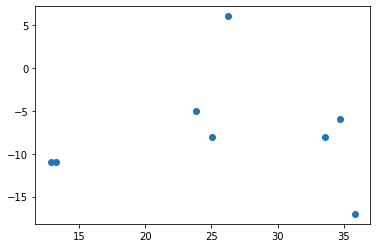

In [61]:
 plt.scatter(APM['Total Minutes Played']
            ,APM['Plus-Minus']
           )

In [62]:
HPM = pd.DataFrame(playerPM['H']).T[['pm','tmp']].rename(columns={'pm':'Plus-Minus','tmp':'Total Minutes Played'})
HPM['Total Minutes Played'] = HPM['Total Minutes Played']/60.00
HPM#['Total Minutes Played'].sum()

,Plus-Minus,Total Minutes Played
"CLEMONS,KEITH",9,9.8
"KENNEDY,MARQUISE",9,24.7333
"NORRIS,BRADEN",-10,27.0667
"UGUAK,AHER",12,30.6333
"KAIFES,COOPER",11,20.3167
"WILLIAMSON,LUCAS",7,26.9667
"HALL,TATE",-6,20.4833
"WELCH,TOM",-2,6.83333
"KRUTWIG,CAMERON",10,33.1667


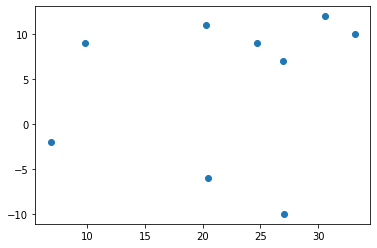

In [63]:
plt.scatter(HPM['Total Minutes Played']
            ,HPM['Plus-Minus']
           )

In [64]:
stints['chg'] = stints['diffEnd']-stints['diffStart']

stints['lA'] = stints['AOF'].apply(len)
stints['lH'] = stints['HOF'].apply(len)

stints['pace'] = (stints['timeEnd']-stints['timeStart']).astype('timedelta64[s]')/(stints['seqEnd']-stints['seqStart'])
stints['timeStart'] = pd.to_timedelta('00:40:00') - stints['timeStart']
stints['timeEnd'] = pd.to_timedelta('00:40:00') - stints['timeEnd']
#stints[['AOF','timeStart','timeEnd','seqStart','seqEnd','diffStart','diffEnd','chg','Y','pace'
#       ,'lA','lH'
#       ]
#      ]

In [65]:
HOME = stints[
    [
        'seqStart'
        ,'seqEnd'
        ,'timeStart'
        ,'timeEnd'
        ,'diffStart'
        ,'diffEnd'
        ,'Y'
        ,'chg'
        ,'pace'
        ,'HX'
    ]
]
HOME[rosterH] = pd.DataFrame(stints.HX.tolist(), index= stints.index)

AWAY = stints[
    [
        'seqStart'
        ,'seqEnd'
        ,'timeStart'
        ,'timeEnd'
        ,'diffStart'
        ,'diffEnd'
        ,'Y'
        ,'chg'
        ,'pace'
        ,'AX'
    ]
]
AWAY[rosterA] = pd.DataFrame(stints.AX.tolist(), index= stints.index)

C:\Users\scohendevries\AppData\Local\Continuum\miniconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


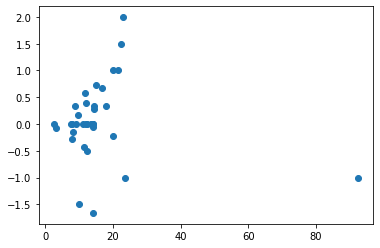

In [66]:
plt.scatter(stints['pace'],stints['Y'])

In [67]:
HOME = HOME.rename(columns={
    'seqStart':'Beginning Sequence #'
    ,'seqEnd':'Ending Sequence #'
    ,'timeStart':'Beginning Time Of Play'
    ,'timeEnd':'Ending Time Of Play'
    ,'diffStart': 'Beginning Point Differential (Home)'
    ,'diffEnd': 'Ending Point Differential (Home)'
    ,'chg': 'Change (Home)'
    ,'Y': 'Average Point Differential Change Per Posession'
    ,'pace': 'Average Length Of Posession'
}).drop(columns='HX')
AWAY = AWAY.rename(columns={
    'seqStart':'Beginning Sequence #'
    ,'seqEnd':'Ending Sequence #'
    ,'timeStart':'Beginning Time Of Play'
    ,'timeEnd':'Ending Time Of Play'
    ,'diffStart': 'Beginning Point Differential (Home)'
    ,'diffEnd': 'Ending Point Differential (Home)'
    ,'Y': 'Average Point Differential Change Per Posession'
    ,'pace': 'Average Length Of Posession'
}).drop(columns='AX')

In [68]:
HOME

,Beginning Sequence #,Ending Sequence #,Beginning Time Of Play,Ending Time Of Play,Beginning Point Differential (Home),Ending Point Differential (Home),Average Point Differential Change Per Posession,chg,Average Length Of Posession,"CLEMONS,KEITH","HALL,TATE","KAIFES,COOPER","KENNEDY,MARQUISE","KRUTWIG,CAMERON","NORRIS,BRADEN","UGUAK,AHER","WELCH,TOM","WILLIAMSON,LUCAS"
0,0,18,00:40:00,00:35:45,0.0,-1.0,-0.055556,-1.0,14.166667,0,1,0,0,1,1,1,0,1
0,18,20,00:35:45,00:35:17,-1.0,-1.0,0.000000,0.0,14.000000,1,1,0,1,1,0,0,0,1
0,20,22,00:35:17,00:34:37,-1.0,1.0,1.000000,2.0,20.000000,1,0,1,1,1,0,1,0,0
0,22,25,00:34:37,00:33:43,1.0,2.0,0.333333,1.0,18.000000,1,0,1,1,1,0,1,0,0
0,25,29,00:33:43,00:32:49,2.0,2.0,0.000000,0.0,13.500000,1,0,1,1,0,0,1,1,0
0,29,31,00:32:49,00:32:02,2.0,0.0,-1.000000,-2.0,23.500000,0,0,1,1,0,1,1,1,0
0,31,33,00:32:02,00:31:57,0.0,0.0,0.000000,0.0,2.500000,0,0,1,1,0,1,0,1,1
0,33,40,00:31:57,00:30:37,0.0,-3.0,-0.428571,-3.0,11.428571,0,1,1,0,1,1,0,0,1
0,40,46,00:30:37,00:29:14,-3.0,-3.0,0.000000,0.0,13.833333,1,1,0,0,1,1,0,0,1
0,46,53,00:29:14,00:28:18,-3.0,-5.0,-0.285714,-2.0,8.000000,1,0,0,0,0,1,1,1,1


In [69]:
AWAY

,Beginning Sequence #,Ending Sequence #,Beginning Time Of Play,Ending Time Of Play,Beginning Point Differential (Home),Ending Point Differential (Home),Average Point Differential Change Per Posession,chg,Average Length Of Posession,"BELL,THOMAS","HAMLET,JAVION","JONES,RUBIN","LEWIS II,TERENCE","MCBRIDE,MARDREZ","MURRAY,JJ","REESE,JAMES","SIMMONS,ZACHARY"
0,0,18,00:40:00,00:35:45,0.0,-1.0,-0.055556,-1.0,14.166667,-1,-1,0,0,-1,0,-1,-1
0,18,20,00:35:45,00:35:17,-1.0,-1.0,0.000000,0.0,14.000000,-1,-1,0,0,-1,0,-1,-1
0,20,22,00:35:17,00:34:37,-1.0,1.0,1.000000,2.0,20.000000,-1,-1,-1,0,0,0,-1,-1
0,22,25,00:34:37,00:33:43,1.0,2.0,0.333333,1.0,18.000000,0,-1,-1,-1,0,0,-1,-1
0,25,29,00:33:43,00:32:49,2.0,2.0,0.000000,0.0,13.500000,-1,-1,-1,-1,0,-1,0,0
0,29,31,00:32:49,00:32:02,2.0,0.0,-1.000000,-2.0,23.500000,-1,0,-1,-1,-1,0,-1,0
0,31,33,00:32:02,00:31:57,0.0,0.0,0.000000,0.0,2.500000,-1,0,-1,0,-1,-1,-1,0
0,33,40,00:31:57,00:30:37,0.0,-3.0,-0.428571,-3.0,11.428571,-1,0,-1,0,-1,0,-1,-1
0,40,46,00:30:37,00:29:14,-3.0,-3.0,0.000000,0.0,13.833333,-1,-1,0,0,-1,0,-1,-1
0,46,53,00:29:14,00:28:18,-3.0,-5.0,-0.285714,-2.0,8.000000,-1,-1,-1,-1,0,-1,0,0


In [71]:
fName = gameID.split('/')[0]
writer = pd.ExcelWriter(fName + '.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
HOME.to_excel(writer, sheet_name='HOME')
AWAY.to_excel(writer, sheet_name='AWAY')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# 